In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mp
import matplotlib.pyplot as plt
import math as m
import sympy as smp
import IPython.display as disp
%matplotlib inline

Имеющиеся экспериментальные данные:

* $R ↦ t$
* комнатная температура (исходная температура образцов), $R_{ambient}$ (измерение R при комнатной температуре)
* приборные константы:
    * масса образца $m$
    * напряжение на нагревателе $U$
    * ток через нагреватель $I$
    * температурный коэффициент сопротивления материала нагревателя $\alpha$

In [2]:
data = {}
work = {}

def append(kind, *args):
    for arg in args:
        if kind not in work:
            work[kind] = arg
        else:
            work[kind] = work[kind].combine_first(arg)

def append_all(*args):
    for kind in kinds:
        append(kind, *args)

def read_csv(name):
    return pd.read_csv(name)

kinds = ["empty", "brass", "iron"]
colors = {
    "empty": "black",
    "brass": "#808000",
    "iron": "#800080"
}

constants = read_csv("constants.csv")

for kind in kinds:
    data[kind] = read_csv("measurements/%s.csv" % kind)
    append(kind,
           constants,
           read_csv("constants/%s.csv" % kind),
           pd.DataFrame({ "R_ambient": { "Value": data[kind].R[0], "Error": data[kind].Error_R[0] } }).T)
    
for kind in kinds:
    disp.display("Data for kind %s:" % kind, data[kind])

for kind in kinds:
    disp.display("Work variables for kind %s:" % kind, work[kind])


'Data for kind empty:'

,R,Error_R,t,Error_t
0,18.144,0.005,0,0.5
1,18.194,0.005,40,0.5
2,18.244,0.005,84,0.5
3,18.294,0.005,129,0.5
4,18.344,0.005,175,0.5
5,18.394,0.005,223,0.5
6,18.444,0.005,273,0.5
7,18.494,0.005,325,0.5
8,18.544,0.005,378,0.5
9,18.594,0.005,433,0.5


'Data for kind brass:'

,R,Error_R,t,Error_t
0,18.146,0.005,0,0.5
1,18.196,0.005,44,0.5
2,18.246,0.005,105,0.5
3,18.296,0.005,172,0.5
4,18.346,0.005,243,0.5
5,18.396,0.005,315,0.5
6,18.446,0.005,389,0.5
7,18.496,0.005,465,0.5
8,18.546,0.005,544,0.5
9,18.596,0.005,624,0.5


'Data for kind iron:'

,R,Error_R,t,Error_t
0,18.147,0.005,0,0.5
1,18.197,0.005,46,0.5
2,18.247,0.005,110,0.5
3,18.297,0.005,180,0.5
4,18.347,0.005,252,0.5
5,18.397,0.005,327,0.5
6,18.497,0.005,482,0.5
7,18.547,0.005,562,0.5
8,18.597,0.005,644,0.5
9,18.647,0.005,728,0.5


'Work variables for kind empty:'

,Error,Value
I,0.010000,0.30000
R_ambient,0.005000,18.14400
T_ambient,1.000000,24.00000
U,0.100000,36.00000
alpha,0.000005,0.00428
m,0.000000,1.00000


'Work variables for kind brass:'

,Error,Value
I,0.010000,0.30000
R_ambient,0.005000,18.14600
T_ambient,1.000000,24.00000
U,0.100000,36.00000
alpha,0.000005,0.00428
m,0.000100,0.87800


'Work variables for kind iron:'

,Error,Value
I,0.010000,0.30000
R_ambient,0.005000,18.14700
T_ambient,1.000000,25.00000
U,0.100000,36.00000
alpha,0.000005,0.00428
m,0.000100,0.81650


Будем считать, что зависимость $t(R)$ имеет вид $t(R) = e^{R/C} + B$.

Выразим теплоёмкость образца в калориметре (вместе с теплоёмкостью калориметра) через значение $\frac{\partial t}{\partial R}_{R = R_{ambient}}$:

(FIXME: вывод пропущен)

$$C = \frac{P - \lambda(T - T_{ambient})}{\partial T / \partial t}$$

при $T = T_{ambient}$,

$$C = \frac{P}{(\partial T / \partial t)_{T = T_{ambient}}}$$

Найдём $\frac{\partial T}{\partial t}$:

$$R(T) = R_0(1 + \alpha \Delta T)$$

$$\frac{\partial R}{\partial t} = R_0 \alpha \frac{\partial T}{\partial t}$$

Итак,

$$C = \frac{P}{\frac{\partial T}{\partial t}_{T = T_{ambient}}} = \frac{P R_0 \alpha}{\frac{\partial R}{\partial t}_{R = R_{ambient}}} = P R_0 \alpha \frac{\partial t}{\partial R}_{R = R_{ambient}}$$

В свою очередь,

$$P R_0 \alpha \frac{\partial t}{\partial R}_{R = R_{ambient}} = \frac{P R_{ambient} \alpha \frac{\partial t}{\partial R}_{R = R_{ambient}}}{1 + \alpha \Delta T_{ambient}}$$

In [3]:
def x(kind):
    return data[kind].R
def xerr(kind):
    return data[kind].Error_R
def y(kind):
    return data[kind].t
def yerr(kind):
    return data[kind].Error_t
def model(x, b, c):
    return m.e**(x/c) + b
def C(dy_dx_at_ambient, U, I, R_ambient, alpha, T_ambient):
    return (U * I * R_ambient * alpha * dy_dx_at_ambient) / (1 + alpha * T_ambient)
    
model_args = ["b", "c"]
model_str = "e^(x/c) + b"

Построим график $t(R)$.

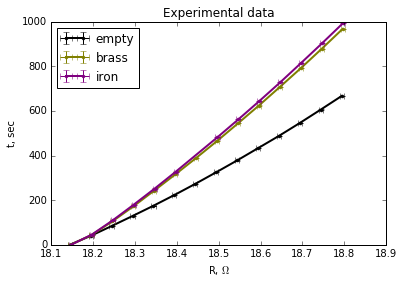

In [4]:
def src_plot_header(title):
    plt.title(title)
    plt.ylabel("t, sec")
    plt.xlabel("R, $\Omega$")

# x, y: data[kind].R, data[kind].t
# xerr, yerr: data[kind].Error_R, yerr = data[kind].Error_t
def src_plot_kind(kind, x, y, label, xerr = None, yerr = None, **kwargs):
    plt.errorbar(x = x, y = y, xerr = xerr, yerr = yerr,
                 label = label, color = colors[kind],
                 **kwargs)
    
def src_plot_footer():
    # let's count time strictly from 0
    plt.axis([None, None, 0, None])
    plt.legend(loc = "best")
        
src_plot_header(title = "Experimental data")

for kind in kinds:
    src_plot_kind(kind, x = x(kind), y = y(kind),
                  xerr = xerr(kind), yerr = yerr(kind),
                  label = kind,
                  linestyle = "-", marker = ".",
                  linewidth = 2, elinewidth = 1)

src_plot_footer()

Выполним приближение модельной функции $t(R)$ к экспериментальным данным методом наименьших квадратов и затем Deming regression.

Initial guesses for empty:
       Error        Value
b  1.399899 -2127.700154
c  0.000173     2.369040


'Final guesses for empty:'

,Error,Value
b,12.229929,-2122.372718
c,0.001544,2.369706


Initial guesses for brass:
       Error        Value
b  1.348299 -2988.088187
c  0.000109     2.269843


'Final guesses for brass:'

,Error,Value
b,25.106852,-2980.249899
c,0.002069,2.270482


Initial guesses for iron:
       Error        Value
b  1.348748 -3054.980669
c  0.000106     2.263437


'Final guesses for iron:'

,Error,Value
b,23.259529,-3048.935899
c,0.001860,2.263916


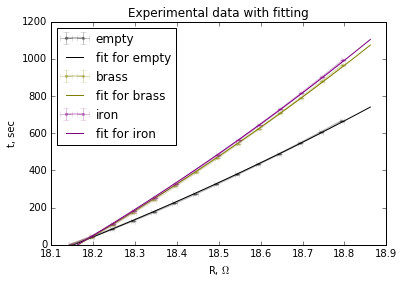

In [5]:
from scipy import optimize as sp_opt
from scipy import odr as sp_odr

def fit_as_string(fit):
    return "%s\n%s" % (model_str,
                       "\n".join(["%s = %s +/- %s" % (n, fit.Value[n], fit.Error[n])
                                  for n in model_args]))

for kind in kinds:
    # use OLS (ordinary least squares) to find initial guesses
    beta, cov = sp_opt.curve_fit(model,
                                 xdata = x(kind),
                                 ydata = y(kind),
                                 sigma = yerr(kind),
                                 absolute_sigma = True, maxfev = 1000000)
    
    fit_result = pd.DataFrame({ "Value": beta,
                                "Error": [cov[i, i]**0.5 for i, v in enumerate(cov)] },
                              index = model_args)
    print("Initial guesses for %s:\n" % kind, fit_result)
    
    # use ODR (Deming regression) which is a special case of TLS (total least squares)
    # to find results accounting for both X and Y uncertainties
    odr_model = sp_odr.Model(lambda B, x: model(x, *B))
    odr_data = sp_odr.RealData(x = x(kind), y = y(kind), sx = xerr(kind), sy = yerr(kind))
    odr = sp_odr.ODR(odr_data, odr_model, beta0 = beta, maxit = 1000000)
    odr_output = odr.run()
    
    fit_result = pd.DataFrame({ "Value": odr_output.beta,
                                "Error": odr_output.sd_beta},
                              index = model_args)
    disp.display("Final guesses for %s:" % kind, fit_result)
    
    append(kind, fit_result)


src_plot_header(title = "Experimental data with fitting")

x_all = [x for x in x(kind) for kind in data]
x_min = min(x_all)
x_max = max(x_all)
x_max += (x_max - x_min) * 0.1
x_linspace = np.linspace(x_min, x_max, 100)

for kind in kinds:
    src_plot_kind(kind, x = x(kind), y = y(kind),
                  xerr = xerr(kind), yerr = yerr(kind),
                  label = kind,
                  linestyle = "-", marker = ".",
                  linewidth = 2, elinewidth = 1, alpha = 0.25)
    src_plot_kind(kind, x = x_linspace, y = model(x_linspace, *work[kind].Value[model_args]),
                  linewidth = 1, label = "fit for %s" % kind)
    
src_plot_footer()

Используя полученные коэффициенты, продифференцируем модельную функцию $t(R)$ по $R$ в точке $R_{ambient}$ и подставим значения в основную формулу.

Таким образом найдём полную теплоёмкость пустого калориметра, после чего модифицируем основную формулу и для каждого из образцов будем находить удельную теплоёмкость образца: $c = \frac{C - C_{empty}}{m}$.

In [6]:
sym_x = smp.symbols("x")
sym_args = smp.symbols(model_args)
sym_model = model(sym_x, *sym_args)
dy_dx = smp.diff(sym_model, sym_x)

print("Model: %s" % sym_model)
print("dy/dx: %s" % dy_dx)

#
# Generate final symbolic expression for C.
#

sym_U, sym_I, sym_R_ambient, sym_alpha, sym_T_ambient, sym_m = smp.symbols("U I R_ambient alpha T_ambient m")
sym_C = C(U = sym_U,
          I = sym_I,
          R_ambient = sym_R_ambient,
          alpha = sym_alpha,
          T_ambient = sym_T_ambient,
          dy_dx_at_ambient = dy_dx.subs(sym_x, sym_R_ambient))
print("Symbolic formula for C: %s" % sym_C)

#
# Now compute its error as square root of sum of squares of products of
# partial differentials of C for each variable by absolute error of the corresponding variable.
#

def error_for(expr, expr_vars):
    expr_err_vars = []
    expr_err_derivs = []
    expr_err_bits = []
    for var in expr_vars:
        err_var = smp.symbols("error_%s" % var.name)
        err_deriv = smp.diff(expr, var)
        expr_err_vars += [err_var]
        expr_err_derivs += [err_deriv]
        expr_err_bits += [(err_deriv*err_var)**2]
    return smp.sqrt(sum(expr_err_bits)), expr_err_vars

def substitutions(expr_vars, expr_err_vars, data):
    var_pairs = { var: data.Value[var.name]
                  for var
                  in expr_vars }
    err_pairs = { err_var: data.Error[var.name]
                  for var, err_var
                  in zip(expr_vars, expr_err_vars) }

    var_pairs.update(err_pairs)
    return var_pairs

def compute_with_error(name, expr, data):
    expr_vars = expr.atoms(smp.Symbol)
    expr_err, expr_err_vars = error_for(expr, expr_vars)
    expr_subs = substitutions(expr_vars, expr_err_vars, data)
    
#    bits = pd.DataFrame({ var.name: { "Error": data.Error[var.name],
#                                      "Derivative": deriv.subs(expr_subs),
#                                      "(E*D)**2": bit.subs(expr_subs) }
#                          for var, deriv, bit in zip(expr_vars, expr_err_derivs, expr_err_bits) }).T
#    disp.display("Error values while computation:", bits)
    
    return pd.DataFrame({ name: { "Value": expr.subs(expr_subs), "Error": expr_err.subs(expr_subs) }}).T

disp.display("C for empty" )
append_all(compute_with_error("C_empty", sym_C, work["empty"]))
disp.display(work["empty"].loc[["C_empty"]])

sym_C_empty = smp.symbols("C_empty")
sym_C = (sym_C - sym_C_empty) / sym_m

for kind in set(kinds) - set(["empty"]):
    disp.display("C for %s" % kind)
    append(kind, compute_with_error("C", sym_C, work[kind]))
    disp.display(work[kind].loc[["C"]])
    

Model: 2.71828182845905**(x/c) + b
dy/dx: 1.0*2.71828182845905**(x/c)/c
Symbolic formula for C: 1.0*2.71828182845905**(R_ambient/c)*I*R_ambient*U*alpha/(c*(T_ambient*alpha + 1))


'C for empty'

,Error,Value
C_empty,23.240097,678.702435


'C for iron'

,Error,Value
C,51.50836,410.154823


'C for brass'

,Error,Value
C,47.323138,355.513503
